# rechunk data and compute spectra 

We use zarr files and apply_ufunc (with a wrapper around scipy.signal.welsh)


---

In [1]:
import os, shutil
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.start_workers(30)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.10:33840 Dashboard: http://10.148.1.10:8787/status,Cluster Workers: 60 Cores: 240 Memory: 3000.00 GB


--- 

# load data

In [5]:
V = ['SSU', 'SSV']

# faces
F = range(13)
#F = range(2)

# parameters for rechunking
Nt = 24*10 # time chunks
#Nc = 96 # x 45 = 4320
#Nc = 48 # x 90 = 4320
Nc = (96, 48)
# other choices: 432, 27 (long scheduling), 288, 864

In [13]:
# try to reintore compression once the computation goes through
# try to delete del statements

overwrite = False

for face in F:

    Efile = scratch+'mit/spectra/%s_f%02d.zarr'%('SSUV',face)
    
    if not os.path.isdir(Efile) or overwrite:
    
        # binary to zarr (standard layout)
        %time zarr_std(V, client,  F=face)

        # rechunk all variables
        %time rechunk(V, F=face, Nt=Nt, Nc=Nc)

        # load data
        dsu = xr.open_zarr(scratch+'mit/rechunked/%s_f%02d.zarr'%('SSU',face))
        dsv = xr.open_zarr(scratch+'mit/rechunked/%s_f%02d.zarr'%('SSV',face))
        ds = xr.merge([dsu,dsv], compat='identical')
        #ds = ds.assign_coords(time_days=ds['time']/86400.)

        # try to delete this file writing once the computation goes through
        ds['SSUV'] = ds['SSU'].fillna(0.) + 1j * ds['SSV'].fillna(0.)
        del ds['SSU'], ds['SSV']
        store_zarr(ds, scratch+'mit/spectra/SSUV_tmp.zarr', 
                   encoding={'SSUV': {'compressor': None}})
        print('SSUV stored')
        del ds
        ds = xr.open_zarr(scratch+'mit/spectra/SSUV_tmp.zarr')

        # need to run once to get frequency
        f, E = get_E(ds['SSUV'].isel(i=slice(2),j=slice(2)))
        #
        E = get_E(ds['SSUV'], f=f)

        # store
        E = E.to_dataset()
        # tmp, waiting for xarray release 
        for v in E.variables:
            if hasattr(E[v],'encoding') and 'chunks' in E[v].encoding:
                del E[v].encoding['chunks']    
        #
        %time E.to_zarr(Efile, mode='w', \
                        encoding={'SSUV': {'compressor': None}})
        del E

        # clean up
        for v in V:
            shutil.rmtree(scratch+'mit/standard/%s.zarr' %v)
            shutil.rmtree(scratch+'mit/rechunked/%s_f%02d.zarr'%(v,face))
    
    print('--- face %d done'%face)

--- face 0 done
--- face 1 done
--- face 2 done
--- face 3 done
--- face 4 done
--- face 5 done
--- face 6 done
--- face 7 done
--- face 8 done
--- face 9 done
--- face 10 done


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


 SSU converted to zarr,  data is 422.4GB 
 SSV converted to zarr,  data is 413.4GB 
CPU times: user 5min 31s, sys: 20.2 s, total: 5min 52s
Wall time: 10min 9s
 SSU face=11  data is 629.5GB 
 SSV face=11  data is 629.6GB 
CPU times: user 18min 45s, sys: 43.9 s, total: 19min 29s
Wall time: 25min 45s
SSUV stored
CPU times: user 24min 37s, sys: 27 s, total: 25min 4s
Wall time: 32min 40s
--- face 11 done


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:249: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


 SSU converted to zarr,  data is 237.4GB 
 SSV converted to zarr,  data is 238.0GB 
CPU times: user 2min 52s, sys: 10.4 s, total: 3min 3s
Wall time: 7min 24s
 SSU face=12  data is 629.7GB 
 SSV face=12  data is 629.7GB 
CPU times: user 17min 6s, sys: 40.4 s, total: 17min 46s
Wall time: 22min 56s
SSUV stored
CPU times: user 20min 55s, sys: 25.5 s, total: 21min 21s
Wall time: 29min 18s
--- face 12 done


---
# inspect result

In [19]:
face=1
v = 'SSUV'
E = xr.open_zarr(scratch+'mit/spectra/%s_f%02d.zarr'%(v,face))[v].fillna(0.)
E = E.persist()
print(E)
print('\n data size: %.1f GB' %(E.nbytes / 1e9))

<xarray.DataArray 'SSUV' (j: 4320, i: 4320, freq_time: 1920)>
dask.array<shape=(4320, 4320, 1920), dtype=float64, chunksize=(48, 96, 1920)>
Coordinates:
    face       int64 ...
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 -11.96 -11.95 -11.94 ...
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

 data size: 286.7 GB


In [21]:
print(E.min().values)
print(E.max().values)
# for some reason there are few crazy values, to verify
E = E.where(abs(E)<1e10, other=0.)

0.0
inf


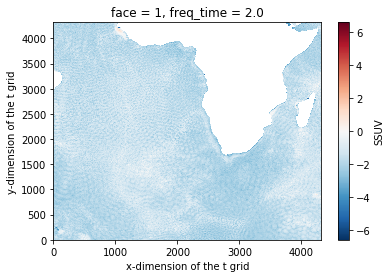

In [22]:
np.log10(E.sel(freq_time=2., method='nearest')).plot()

In [23]:
df = E.freq_time[1]-E.freq_time[0]
E2 = E.where(abs(abs(E.freq_time)-2.)<.2, other=0.).sum(dim='freq_time')*df
E2 = E2.where(E2>0)
print(E2)

<xarray.DataArray (j: 4320, i: 4320)>
dask.array<shape=(4320, 4320), dtype=float64, chunksize=(48, 96)>
Coordinates:
    face     int64 1
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...


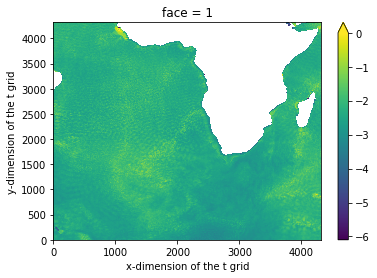

In [24]:
np.log10(E2).plot(vmax=0)

---

In [9]:
w = cluster.start_workers(10)

In [25]:
# kill scheduler, workers
cluster.scheduler.close()
#cluster.stop_workers(cluster.jobs)

<Future pending cb=[_make_coroutine_wrapper.<locals>.wrapper.<locals>.<lambda>() at /home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py:336]>

In [ ]:
client.restart()